In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe, gaussian_vel_reconstruction

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)
    

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')
psi0 = 210.0
Rc = 4.0
xc, yc = 0, 0 
q11, q12, q22 = .002, 0.001, .002

dx, dy = X-xc, Y-yc
rho      = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
rho_x    = 2*q11*dx   + 2*q12*dy
rho_y    = 2*q12*dx   + 2*q22*dy
exp_t    = np.exp(-rho/Rc**2)
u   =  psi0/Rc**2 * rho_y * exp_t
v   = -psi0/Rc**2 * rho_x * exp_t

df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q11', 'Q12', 'Q22', 'Rc', 'psi0', 'q11', 'q12', 'q22'])
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': 2*(q11+q22),
                           'Q11': -psi0 / Rc**2 * q11, 'Q12': -psi0 / Rc**2 * q12, 'Q22': -psi0 / Rc**2 * q22, 
                           'Rc': Rc, 'psi0': psi0, 'q11': q11, 'q12': q12, 'q22': q22}


In [4]:
nic, njc = 53, 53
r = 8

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])


dic_tests = {}
for test in df_tests.index:
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))

    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    y2 = y[data.njc-data.r:data.njc+data.r+1]
    x2 = np.array([x[data.nic]] * len(y2))

    u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1]
    v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1]

    xc, yc, w, Q, Rc, psi0 = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, Rc_init=4.0, psi0_init=210.0)
    q = Q
    
    dic_tests[test] = {'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
                       'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
                       'name': test}
    df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w,
                               'Q11': Q[0,0], 'Q12': Q[0,1], 'Q22': Q[1,1],
                               'Rc': Rc, 'psi0': psi0,
                               'q11': q[0,0], 'q12': q[1,0], 'q22': q[1,1]}
df_res.index = ['Control'] +  list(df_tests.index)
df_res


,xc,yc,w,Q11,Q12,Q22,Rc,psi0,q11,q12,q22
Control,0.000000,0.000000,0.008000,-0.026250,-0.013125,-0.026250,4.0,210.0,0.002000,0.001000,0.002000
P1,-0.123956,-0.123956,-0.101744,-0.025436,-0.012688,-0.025436,NaN,NaN,-0.025436,-0.012688,-0.025436
P2,0.939247,-0.939247,-0.089164,-0.022291,-0.011248,-0.022291,NaN,NaN,-0.022291,-0.011248,-0.022291
P3,-15.858094,-15.858094,-0.127875,-0.031969,-0.011324,-0.031969,NaN,NaN,-0.031969,-0.011324,-0.031969
L1,-0.036768,-0.036768,-0.103359,-0.025840,-0.012932,-0.025840,NaN,NaN,-0.025840,-0.012932,-0.025840
L2,-0.123956,-0.123956,-0.101744,-0.025436,-0.012688,-0.025436,NaN,NaN,-0.025436,-0.012688,-0.025436
L3,-0.196900,-0.196900,-0.099682,-0.024921,-0.012379,-0.024921,NaN,NaN,-0.024921,-0.012379,-0.024921


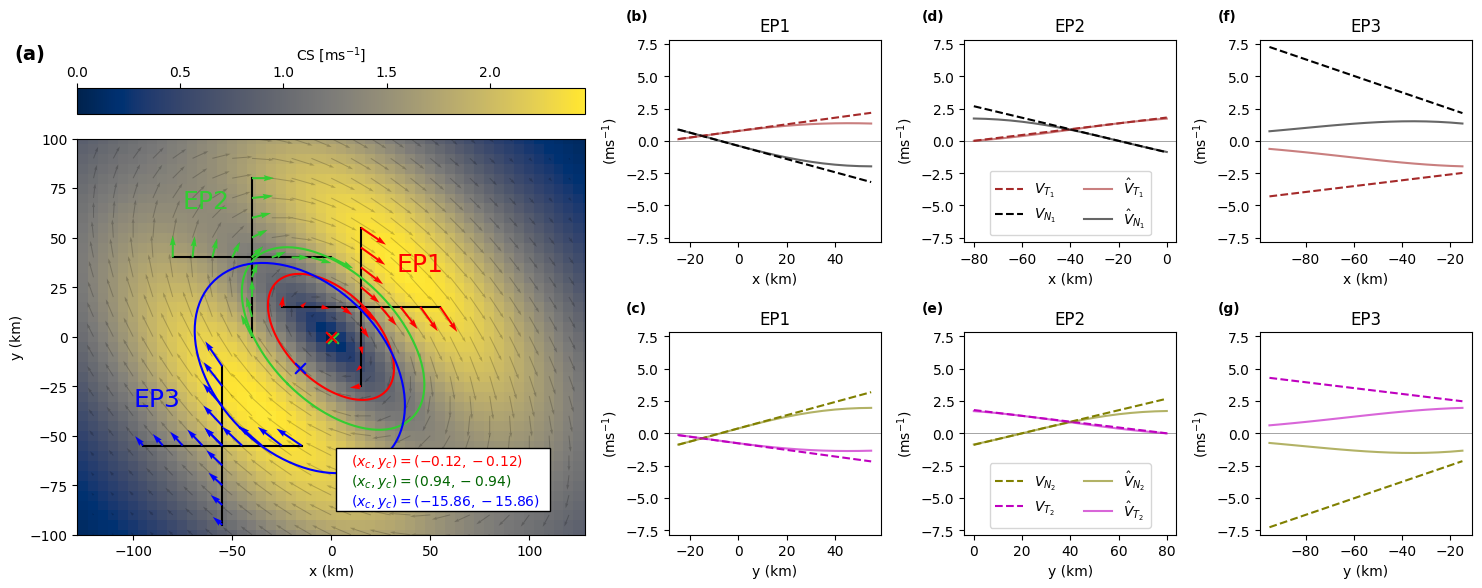

In [5]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [ms$^{-1}$]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)


# colours = ['r', 'darkgreen', 'b']
colours = ['r', 'limegreen', 'b']

i = 0
scales = [40, 58, 65]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
 
        ax_main.plot(x1, y1, 'k', zorder=1)
        ax_main.plot(x2, y2, 'k', zorder=1)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(data.xc, data.yc, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        Q = np.array([[data.Q11, data.Q12], [data.Q12, data.Q22]])
        x_ellipse, y_ellipse = plot_ellipse(Q, center=(data.xc, data.yc), scale=scales[i])
        ax_main.plot(x_ellipse, y_ellipse, color=colours[i])
        
        ax_main.text(10, -65 - 10*i, fr'$(x_c,y_c)=({data.xc:.2f},{data.yc:.2f})$', color='darkgreen' if '2' in dic['name'] else colours[i], zorder=11)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black', zorder=10)
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)', 'EP1'), ('(f)','(g)', 'EP3'), ('(d)','(e)', 'EP2')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(x1, v1)
        A1, A0 = tang_at_root(x1, u1, root_x)
        B1, B0 = tang_at_root(x1, v1, root_x)
        p_u1 = A1*x1 + A0
        p_v1 = B1*x1 + B0

        root_y = find_root(y2, u2)
        C1, C0 = tang_at_root(y2, u2, root_y)
        D1, D0 = tang_at_root(y2, v2, root_y)
        p_u2 = C1*y2 + C0
        p_v2 = D1*y2 + D0
    
        ax2.plot(x1, p_u1, linestyle='--', color='brown', label=r'$V_{T_1}$')
        ax2.plot(x1, p_v1, 'k--', label=r'$V_{N_1}$')
        ax2.plot(x1, u1, color='brown', label=r'$\hat{V}_{T_1}$', alpha=.6)#, color=colours[i])
        ax2.plot(x1, v1, 'k', label=r'$\hat{V}_{N_1}$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(ms$^{-1}$)')
        ax2.set_xlabel(r'x (km)')
        if '2' in dic['name']:
            ax2.legend(loc='lower center', ncol=2)
        ax2.set_title(tags[2-j][2])
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])
        
        ax3.plot(y2, p_u2, linestyle='--', color='olive', label=r'$V_{N_2}$')
        ax3.plot(y2, p_v2, 'm--', label=r'$V_{T_2}$')
        ax3.plot(y2, u2, color='olive', label=r'$\hat{V}_{N_2}$', alpha=.6)#, color=colours[i])
        ax3.plot(y2, v2, 'm', label=r'$\hat{V}_{T_2}$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(ms$^{-1}$)')
        ax3.set_xlabel(r'y (km)')
        if '2' in dic['name']:
            ax3.legend(loc='lower center', ncol=2)
        ax3.set_title(tags[2-j][2])
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

ax_main.text(33, 33, 'EP1', color='r', zorder=3, fontsize=18)
ax_main.text(-75, 65, 'EP2', color='limegreen', zorder=3, fontsize=18)
ax_main.text(-100, -35, 'EP3', color='b', zorder=3, fontsize=18)

plt.tight_layout()
plt.show()


In [6]:
df_res


,xc,yc,w,Q11,Q12,Q22,Rc,psi0,q11,q12,q22
Control,0.000000,0.000000,0.008000,-0.026250,-0.013125,-0.026250,4.0,210.0,0.002000,0.001000,0.002000
P1,-0.123956,-0.123956,-0.101744,-0.025436,-0.012688,-0.025436,NaN,NaN,-0.025436,-0.012688,-0.025436
P2,0.939247,-0.939247,-0.089164,-0.022291,-0.011248,-0.022291,NaN,NaN,-0.022291,-0.011248,-0.022291
P3,-15.858094,-15.858094,-0.127875,-0.031969,-0.011324,-0.031969,NaN,NaN,-0.031969,-0.011324,-0.031969
L1,-0.036768,-0.036768,-0.103359,-0.025840,-0.012932,-0.025840,NaN,NaN,-0.025840,-0.012932,-0.025840
L2,-0.123956,-0.123956,-0.101744,-0.025436,-0.012688,-0.025436,NaN,NaN,-0.025436,-0.012688,-0.025436
L3,-0.196900,-0.196900,-0.099682,-0.024921,-0.012379,-0.024921,NaN,NaN,-0.024921,-0.012379,-0.024921


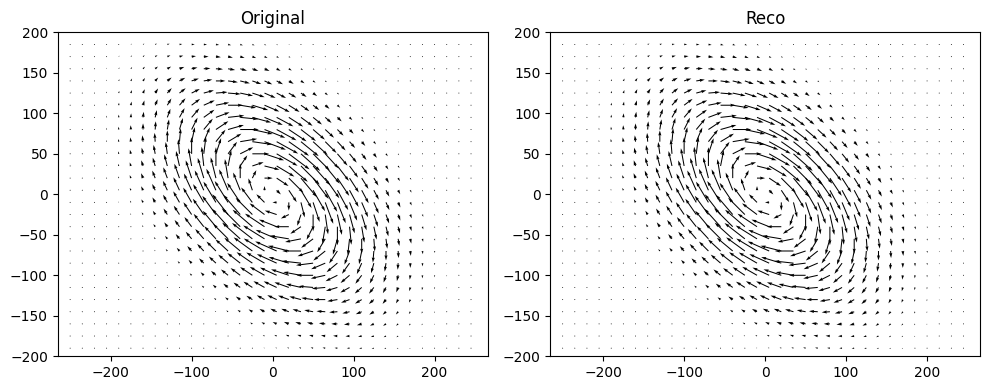

In [7]:
data = df_res.iloc[0]

spac, scale = 3, 40
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].quiver(
    x[::spac], y[::spac],
    u[::spac, ::spac].T, v[::spac, ::spac].T,
    scale=scale,
)
axs[0].axis('equal')
axs[0].set_xlim(-200, 200)
axs[0].set_ylim(-200, 200)
axs[0].set_title('Original')

u_reco, v_reco, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.q11, data.q12, data.q22, data.Rc, data.psi0, X, Y)

axs[1].quiver(X[::spac,::spac], Y[::spac,::spac], u_reco[::spac,::spac], v_reco[::spac,::spac], scale=scale)
axs[1].axis('equal')
axs[1].set_xlim(-200, 200)
axs[1].set_ylim(-200, 200)
axs[1].set_title('Reco')

plt.tight_layout()


In [8]:
data

xc        0.000000
yc        0.000000
w         0.008000
Q11      -0.026250
Q12      -0.013125
Q22      -0.026250
Rc        4.000000
psi0    210.000000
q11       0.002000
q12       0.001000
q22       0.002000
Name: Control, dtype: float64

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Time to switch on 

In [ ]:

data_control = df_res.iloc[0]
df_res.head()

In [ ]:
data_control.Q11 /data_control.Q12

In [ ]:
data = pd.DataFrame({'nic': [48], 'njc': [48], 'r': [10]}).iloc[0]


x1 = x[data.nic-data.r:data.nic+data.r+1]
y1 = np.array([y[data.njc]] * len(x1))

u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

y2 = y[data.njc-data.r:data.njc+data.r+1]
x2 = np.array([x[data.nic]] * len(y2))

u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1]
v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1]

xc, yc, w, Q, Rc, psi0, q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, Rc_init=4.0)

df_core = pd.DataFrame({'xc': [xc], 'yc': [yc], 'Q11': [Q[0,0]], 'Q12': [Q[0,1]], 'Q22': [Q[1,1]]})
data_core = df_core.iloc[0]
df_core
                        

In [ ]:
import numpy as np
from scipy.optimize import least_squares

def fit_eddy(xi, yi, ui, vi, xc, yc, Q11, Q12, Q22, p0=(1,1,1)):
    def residuals(p):
        s, Rc, psi0 = p
        q11, q12, q22 = s*Q11, s*Q12, s*Q22
        dx, dy = xi-xc, yi-yc
        rho      = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
        rho_x    = 2*q11*dx   + 2*q12*dy
        rho_y    = 2*q12*dx   + 2*q22*dy
        exp_t    = np.exp(-rho/Rc**2)
        u_pred   =  psi0/Rc**2 * rho_y * exp_t
        v_pred   = -psi0/Rc**2 * rho_x * exp_t
        return np.concatenate((u_pred-ui, v_pred-vi))
    res = least_squares(residuals, p0)
    s_opt, Rc_opt, psi0_opt = res.x
    return {
      'q11': s_opt*Q11,
      'q12': s_opt*Q12,
      'q22': s_opt*Q22,
      'Rc':  Rc_opt,
      'psi0': psi0_opt,
      's': s_opt
    }
    

In [ ]:
points1 = set(zip(x1, y1))
points2 = set(zip(x2, y2))
common_points = points1 & points2


# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]
y1f = y1[mask]
u1f = u1[mask]
v1f = v1[mask]

xi = np.concatenate([x1f, x2])
yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2])
vi = np.concatenate([v1f, v2])

s_init = -1/13.125 # - Rc**2 / psi0
Rc_init = 4
psi0_init = 210


fit_eddy(xi, yi, ui, vi, data_core.xc, data_core.yc, data_core.Q11, data_core.Q12, data_core.Q22, p0=(s_init, Rc_init, psi0_init))


In [ ]:
4**2/210

In [ ]:
1/13.125